# Introduction to pandas

This notebook introduces the `Series` and `DataFrame` objects in the `pandas` library, as well as their methods. Much of this is based off the [lecture](https://www.quantopian.com/lectures/introduction-to-pandas) on Quantopian, but without using its API. Financial data is fetched off [Quandl](https://www.quandl.com) and uses my own api-key (remove or substitute your own).

*Library imports and style settings*

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sns.set_style(  
    "whitegrid",  
    {  
        'legend.frameon': True,  
    }  
)
mpl.rc('figure', figsize=(14, 8))  

## pandas.Series
We first create a pandas Series, name it and assign a date range to index it.

In [2]:
s = pd.Series([1,2,np.nan,4,5])
s.name = "Toy series"
new_index = pd.date_range("2017-01-01",periods=len(s), freq="D") # datetime list, "B" for weekdays
s.index=new_index
print s

2017-01-01    1.0
2017-01-02    2.0
2017-01-03    NaN
2017-01-04    4.0
2017-01-05    5.0
Freq: D, Name: Toy series, dtype: float64


`Series.iloc` works the same way as python array access.

In [3]:
s.iloc[:2] # last element not included

2017-01-01    1.0
2017-01-02    2.0
Freq: D, Name: Toy series, dtype: float64

`Series.loc` uses the `Series.index` index to fetch data.

In [4]:
s.loc['2017-01-02':'2017-01-04']

2017-01-02    2.0
2017-01-03    NaN
2017-01-04    4.0
Freq: D, Name: Toy series, dtype: float64

We can query the series using boolean operators.

In [5]:
s<3

2017-01-01     True
2017-01-02     True
2017-01-03    False
2017-01-04    False
2017-01-05    False
Freq: D, Name: Toy series, dtype: bool

This allows us to extract the desired values.

In [6]:
s.loc[(s < 5) & (s > 1)]

2017-01-02    2.0
2017-01-04    4.0
Freq: 2D, Name: Toy series, dtype: float64

## Collecting data

The code below pulls data from Quandl and stores it in a `DataFrame`. A `DataFrame` contains columns of `Series` and is essentially a time-series table. We extract the first few elements (the oldest) and the last few elements (most recent) using `Series.head()` and `Series.tail()` respectively.

In [7]:
import requests

def get_stock_data(ticker, start_date, end_date, cols=None):
    url = 'https://www.quandl.com/api/v3/datasets/HKEX/' + ticker + '/data.json'
    params = {
        'start_date': start_date,
        'end_date': end_date,
        'api_key': 'CqRnybn2soNJPpEGZCy8',
        'column_index': cols,
    }
    cache_timeout = 1*60 # in seconds
    try:
        r = requests.get(url,params=params)
    except requests.exceptions.Timeout:
        return 0
    if r.headers['Content-Type'].startswith('text/html'):
        # 404 not found
        return 0
    else:
        return r.json()["dataset_data"]

symbol="02800"
start = "2017-01-01"
end = "2017-09-01"
raw_data = get_stock_data(symbol, start, end)

def parse_raw(rdata):
    result = {}
    for ind,col_name in enumerate(rdata["column_names"][1:]):
        result[col_name] = [i[ind+1] for i in rdata["data"]]
    return result

data = pd.DataFrame(data=parse_raw(raw_data),index=pd.DatetimeIndex([i[0] for i in raw_data["data"]]))
print data.head(5)

prices = data["Nominal Price"]

              Ask    Bid  Change (%)   High  Lot Size    Low  Net Change  \
2017-09-01  28.80  28.75       0.000  28.95     500.0  28.70        0.00   
2017-08-31  28.80  28.75      -0.347  28.85     500.0  28.70       -0.10   
2017-08-30  28.90  28.85       1.228  28.90     500.0  28.55        0.35   
2017-08-29  28.50  28.45      -0.524  28.60     500.0  28.40       -0.15   
2017-08-28  28.65  28.60       0.350  28.80     500.0  28.50        0.10   

            Nominal Price P/E(x)  Previous Close  Share Volume ('000)  \
2017-09-01          28.75   None           28.75              19970.0   
2017-08-31          28.75   None           28.85              22870.0   
2017-08-30          28.85   None           28.50              25447.0   
2017-08-29          28.50   None           28.65              52203.0   
2017-08-28          28.65   None           28.55              17863.0   

            Turnover ('000)  
2017-09-01         575978.0  
2017-08-31         657731.0  
2017-08-30    

Resample the data to a different frequency using `Series.resample()`. This produces a `DatetimeIndexResampler` object, where the resampling method is then called using e.g. `DatetimeIndexResampler.mean()` to use the mean of the lower level data to create the higher level data, or `DatetimeIndexResampler.median()`.

In [8]:
monthly_prices = prices.resample("M").mean()
monthly_prices.tail(5)

2017-05-31    25.402632
2017-06-30    26.213636
2017-07-31    26.966667
2017-08-31    28.236957
2017-09-30    28.750000
Freq: M, Name: Nominal Price, dtype: float64

A custom resampler can also be used, such as the `custom_resampler()` function we create below, which samples based on the price on the first day of the month.

In [9]:
def custom_resampler(array_like):
    """ Returns the first value of the period """
    return array_like[0]

first_of_month_prices=prices.resample("M").apply(custom_resampler)
first_of_month_prices.tail(5)

2017-05-31    24.80
2017-06-30    26.00
2017-07-31    26.25
2017-08-31    28.20
2017-09-30    28.75
Freq: M, Name: Nominal Price, dtype: float64

Suppose we want to align our data to another set of data, which might have different indices. We can use `DataFrame.reindex()` to do this. For example, suppose we want a table with entries for all days between `start` and `end`:

In [10]:
calendar_dates = pd.date_range(start=start, end=end, freq='D')
calendar_prices = data.reindex(calendar_dates, method='ffill')
calendar_prices.tail(15)

,Ask,Bid,Change (%),High,Lot Size,Low,Net Change,Nominal Price,P/E(x),Previous Close,Share Volume ('000),Turnover ('000)
2017-08-18,27.80,27.75,-1.070,27.95,500.0,27.65,-0.30,27.75,None,28.05,25916.0,720487.0
2017-08-19,27.90,27.85,0.541,27.95,500.0,27.75,0.15,27.90,None,27.75,21100.0,587846.0
2017-08-20,27.90,27.85,0.541,27.95,500.0,27.75,0.15,27.90,None,27.75,21100.0,587846.0
2017-08-21,27.90,27.85,0.541,27.95,500.0,27.75,0.15,27.90,None,27.75,21100.0,587846.0
2017-08-22,28.15,28.10,0.896,28.25,500.0,28.00,0.25,28.15,None,27.90,21326.0,600223.0
2017-08-23,NaN,NaN,0.000,NaN,500.0,NaN,0.00,28.15,None,28.15,0.0,0.0
2017-08-24,28.25,28.20,0.178,28.35,500.0,28.15,0.05,28.20,None,28.15,33181.0,937651.0
2017-08-25,28.60,28.55,1.241,28.60,500.0,28.15,0.35,28.55,None,28.20,31410.0,893979.0
2017-08-26,28.65,28.60,0.350,28.80,500.0,28.50,0.10,28.65,None,28.55,17863.0,512328.0
2017-08-27,28.65,28.60,0.350,28.80,500.0,28.50,0.10,28.65,None,28.55,17863.0,512328.0


By using the forward-fill `ffill` method, we are asking to fill the gaps using the last value listed. So the price on a weekend or holiday will be listed as the price on the last market day. Note however that columns that are not supposed to take this behaviour (such as the percentage change column) will still have its value copied down. But we can ignore this for now.

## Missing data

Notice how we still have `NaN`'s even after reindexing with the `ffill` method. This is due to the fact that we had missing data there originally. To deal with this, pandas provides two primary methods: `DataFrame.fillna()` and `DataFrame.dropna()`.

In [11]:
meanfilled_prices = calendar_prices.fillna(calendar_prices.mean())
meanfilled_prices.tail(10)

,Ask,Bid,Change (%),High,Lot Size,Low,Net Change,Nominal Price,P/E(x),Previous Close,Share Volume ('000),Turnover ('000)
2017-08-23,25.425309,25.375103,0.000,25.493827,500.0,25.253292,0.00,28.15,NaN,28.15,0.0,0.0
2017-08-24,28.250000,28.200000,0.178,28.350000,500.0,28.150000,0.05,28.20,NaN,28.15,33181.0,937651.0
2017-08-25,28.600000,28.550000,1.241,28.600000,500.0,28.150000,0.35,28.55,NaN,28.20,31410.0,893979.0
2017-08-26,28.650000,28.600000,0.350,28.800000,500.0,28.500000,0.10,28.65,NaN,28.55,17863.0,512328.0
2017-08-27,28.650000,28.600000,0.350,28.800000,500.0,28.500000,0.10,28.65,NaN,28.55,17863.0,512328.0
2017-08-28,28.650000,28.600000,0.350,28.800000,500.0,28.500000,0.10,28.65,NaN,28.55,17863.0,512328.0
2017-08-29,28.500000,28.450000,-0.524,28.600000,500.0,28.400000,-0.15,28.50,NaN,28.65,52203.0,1488596.0
2017-08-30,28.900000,28.850000,1.228,28.900000,500.0,28.550000,0.35,28.85,NaN,28.50,25447.0,731984.0
2017-08-31,28.800000,28.750000,-0.347,28.850000,500.0,28.700000,-0.10,28.75,NaN,28.85,22870.0,657731.0
2017-09-01,28.800000,28.750000,0.000,28.950000,500.0,28.700000,0.00,28.75,NaN,28.75,19970.0,575978.0


So this fills all the `NaN`'s with the mean price of all days. But it doesn't really make sense. Instead we can use the `method` parameter, which takes options similar to that of `reindex()`. For example, we can fill the missing piece with data recorded before, using `bfill`.

In [12]:
bfilled_prices = calendar_prices.fillna(method='bfill')
bfilled_prices.tail(10)

,Ask,Bid,Change (%),High,Lot Size,Low,Net Change,Nominal Price,P/E(x),Previous Close,Share Volume ('000),Turnover ('000)
2017-08-23,28.25,28.20,0.000,28.35,500.0,28.15,0.00,28.15,None,28.15,0.0,0.0
2017-08-24,28.25,28.20,0.178,28.35,500.0,28.15,0.05,28.20,None,28.15,33181.0,937651.0
2017-08-25,28.60,28.55,1.241,28.60,500.0,28.15,0.35,28.55,None,28.20,31410.0,893979.0
2017-08-26,28.65,28.60,0.350,28.80,500.0,28.50,0.10,28.65,None,28.55,17863.0,512328.0
2017-08-27,28.65,28.60,0.350,28.80,500.0,28.50,0.10,28.65,None,28.55,17863.0,512328.0
2017-08-28,28.65,28.60,0.350,28.80,500.0,28.50,0.10,28.65,None,28.55,17863.0,512328.0
2017-08-29,28.50,28.45,-0.524,28.60,500.0,28.40,-0.15,28.50,None,28.65,52203.0,1488596.0
2017-08-30,28.90,28.85,1.228,28.90,500.0,28.55,0.35,28.85,None,28.50,25447.0,731984.0
2017-08-31,28.80,28.75,-0.347,28.85,500.0,28.70,-0.10,28.75,None,28.85,22870.0,657731.0
2017-09-01,28.80,28.75,0.000,28.95,500.0,28.70,0.00,28.75,None,28.75,19970.0,575978.0


But this might not be wise either. Both attempts have what is known as *look-ahead bias*, which is bad as we try to fill the gap with data that is unknown or unavailable at that particular time. Perhaps we should just get rid of the data point. This is done using `dropna()`.

In [13]:
dropped_prices = calendar_prices["Ask"].dropna()
dropped_prices.tail(10)

2017-08-22    28.15
2017-08-24    28.25
2017-08-25    28.60
2017-08-26    28.65
2017-08-27    28.65
2017-08-28    28.65
2017-08-29    28.50
2017-08-30    28.90
2017-08-31    28.80
2017-09-01    28.80
Name: Ask, dtype: float64

## Time-series analysis
Each `Series` has a built-in plotting method.

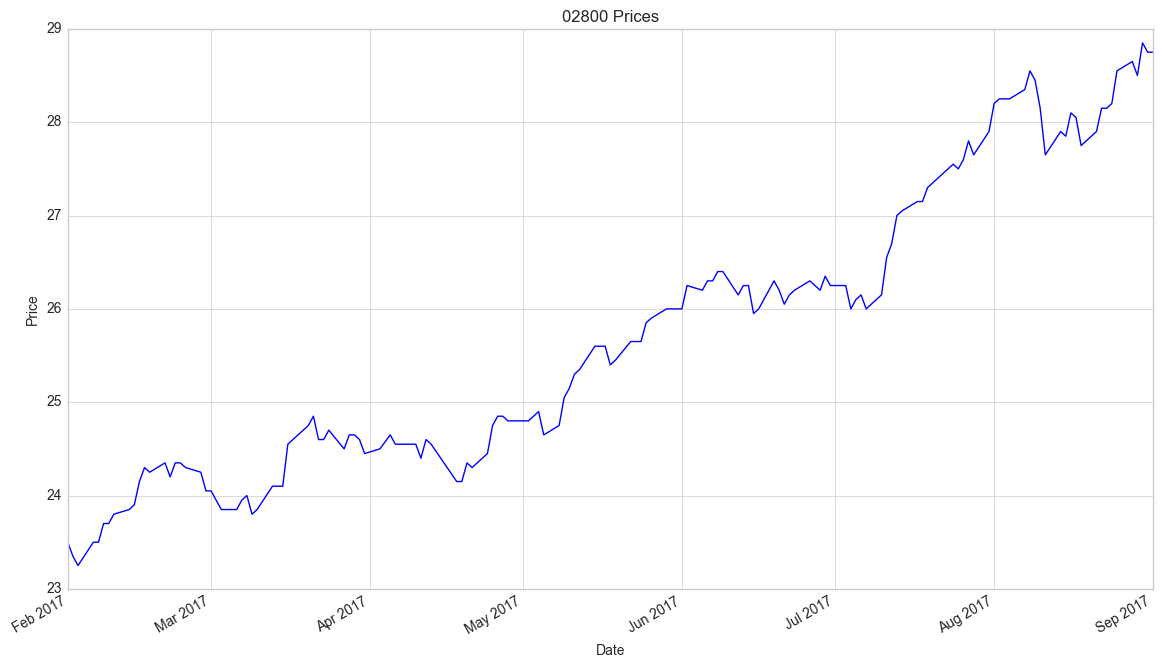

In [14]:
prices.plot()
plt.title(symbol + " Prices")
plt.ylabel("Price")
plt.xlabel("Date")
plt.show()

To calculate some descriptive statistics, one can use `Series.describe()` for a list of stats or individual methods such as `Series.mean()` or `Series.std()`.

In [15]:
prices.describe()

count    146.000000
mean      25.743493
std        1.551076
min       23.250000
25%       24.450000
50%       25.625000
75%       26.925000
max       28.850000
Name: Nominal Price, dtype: float64

We can perform simple linear transformations such as `prices * 2 - 10` or create a linear combination of series.

In [16]:
noisy_prices = prices + 5 * pd.Series(np.random.normal(0, 5, len(prices)), index=prices.index) + 20
noisy_prices.head(5)

2017-09-01    33.614374
2017-08-31    49.823424
2017-08-30    75.217773
2017-08-29    38.868311
2017-08-28    37.713840
dtype: float64

Note that if the indices do not match then we may get an empty series in return (entries are `NaN`). First-order differences can be calculated using `Series.diff()` or `Series.pct_change()`.

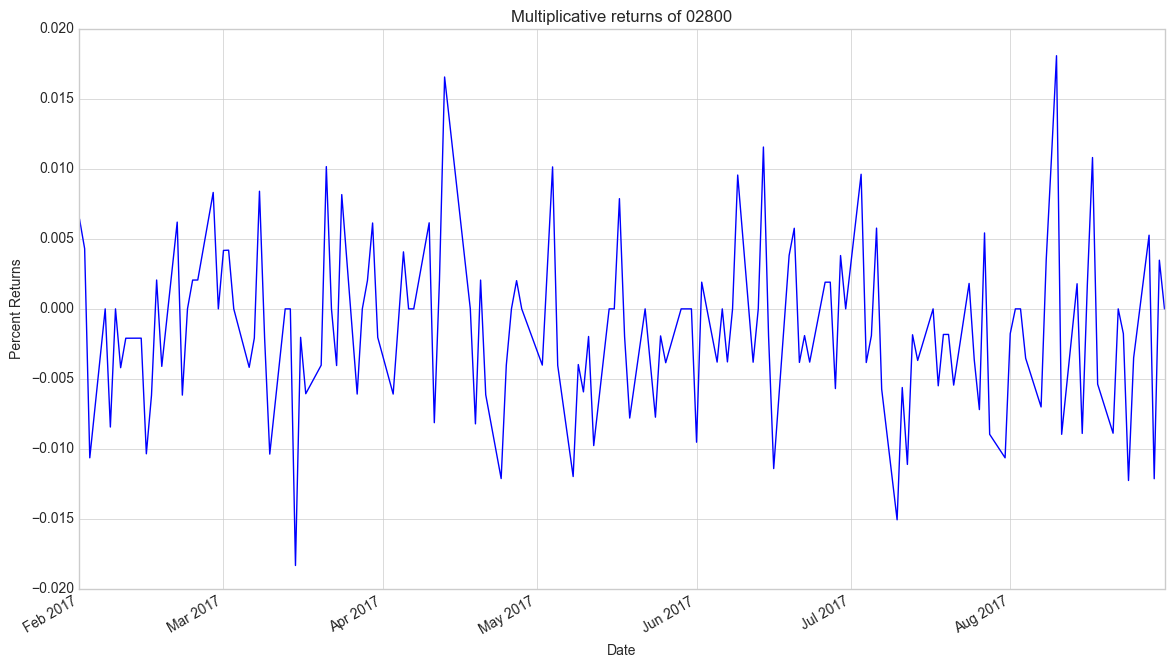

In [17]:
add_returns = prices.diff()[1:]
mult_returns = prices.pct_change()[1:]

plt.title("Multiplicative returns of " + symbol)
plt.xlabel("Date")
plt.ylabel("Percent Returns")
mult_returns.plot()
plt.show()

We can calculate rolling means and standard deviations as well.

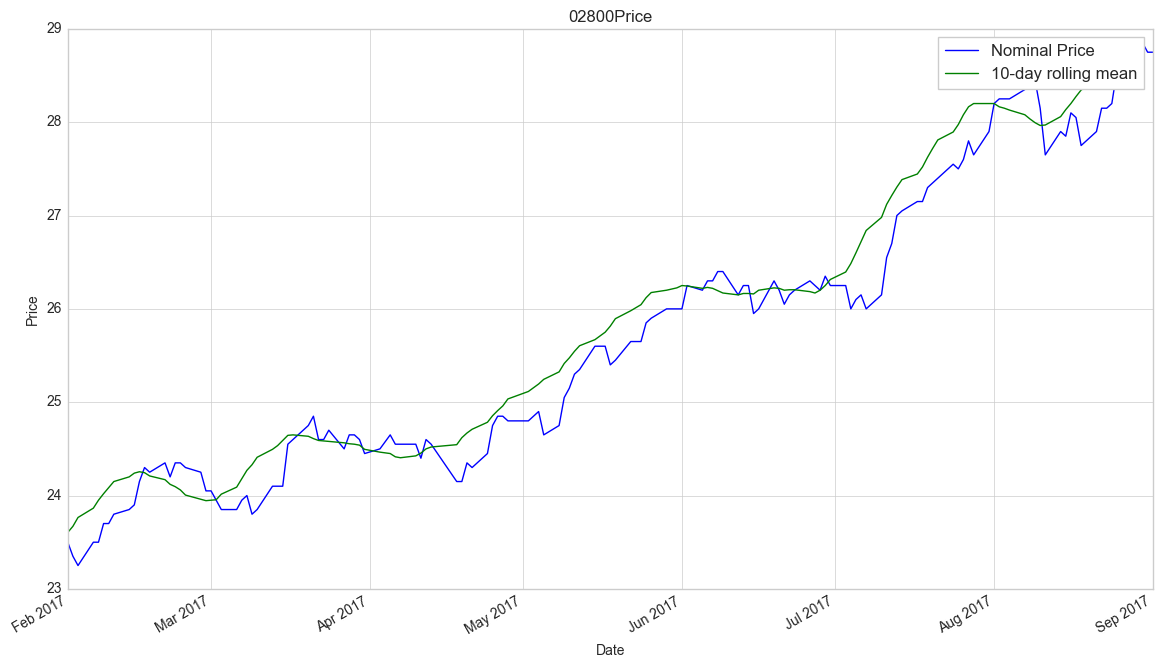

In [18]:
rolling = prices.rolling(window=10,center=False)
rolling_mean = rolling.mean()
rolling_mean.name = "10-day rolling mean"

prices.plot()
rolling_mean.plot()
plt.title(symbol + "Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

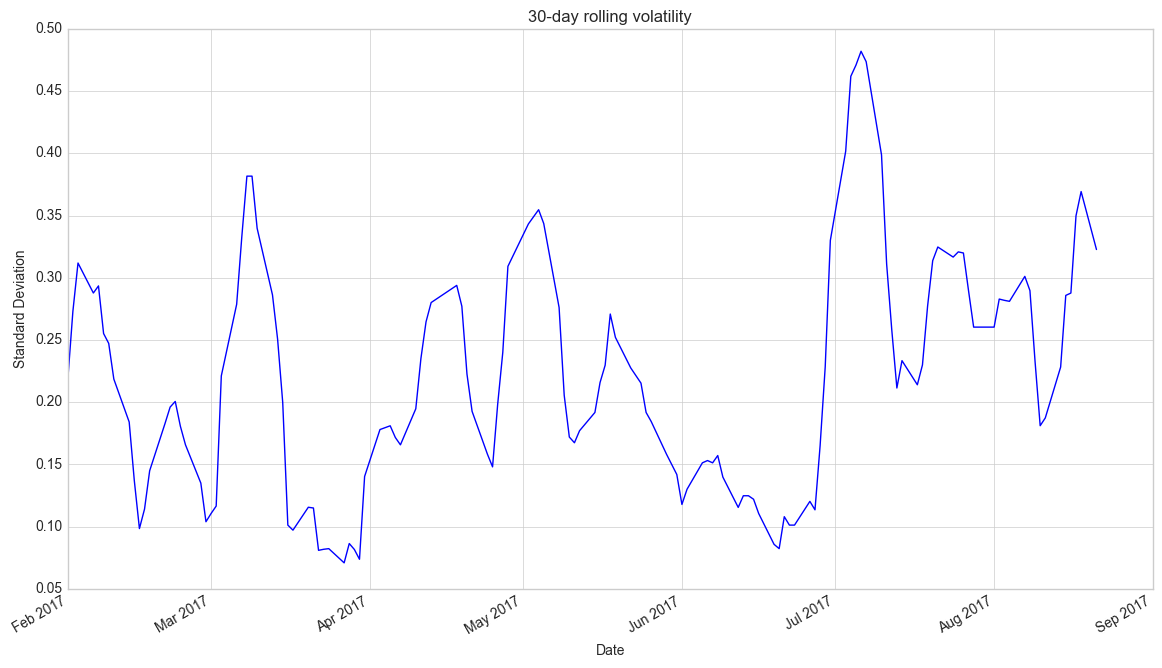

In [19]:
rolling_std = rolling.std()
rolling_std.name = "30-day rolling volatility"

rolling_std.plot()
plt.title(rolling_std.name)
plt.xlabel("Date")
plt.ylabel("Standard Deviation")
plt.show()

Many NumPy functions have been implemented on the `Series` and `DataFrame` objects, such as `numpy.median()`. When available, one should use the built-in functions for pandas as they perform better.

In [20]:
print mult_returns.median()

-0.00182481751825


## pandas.DataFrame

We have already seen the `pandas.DataFrame` object in action. Let's see what else we can do with it.

Given two `pandas.Series`, one can concatenate them into a `pandas.DataFrame` object. The `concat()` method can also be used on two `DataFrame`s to combine them together. Note that since the two `Series` objects below have no assigned indices, they default to integer indices.

In [21]:
s_1 = pd.Series([2, 4, 6, 8, 10], name='Evens')
s_2 = pd.Series([1, 3, 5, 7, 9], name="Odds")
numbers = pd.concat([s_1, s_2], axis=1)
print numbers

   Evens  Odds
0      2     1
1      4     3
2      6     5
3      8     7
4     10     9


The column names can be extracted using the `DataFrame.columns()` method. They can also be changed using assignment.

In [22]:
numbers.columns = ['Shmevens', 'Shmodds']
print numbers.columns
print numbers

Index([u'Shmevens', u'Shmodds'], dtype='object')
   Shmevens  Shmodds
0         2        1
1         4        3
2         6        5
3         8        7
4        10        9


We can modify the indices similarly using `DataFrame.index()`.

Accessing the columns can be done with `loc[]` or just directly, which returns a `Series`.

In [23]:
print data.loc[:,"Share Volume ('000)"].head(5)

2017-09-01    19970.0
2017-08-31    22870.0
2017-08-30    25447.0
2017-08-29    52203.0
2017-08-28    17863.0
Name: Share Volume ('000), dtype: float64


Accessing multiple columns are done using a list, which returns a `DataFrame`.

In [24]:
data.loc[:,["Ask","Share Volume ('000)"]].head(5)

,Ask,Share Volume ('000)
2017-09-01,28.80,19970.0
2017-08-31,28.80,22870.0
2017-08-30,28.90,25447.0
2017-08-29,28.50,52203.0
2017-08-28,28.65,17863.0


Accessing using integer indices works similarly, with `iloc[]`.

In [25]:
data.iloc[:10,[0,1]] # Get Ask/Bid prices of 10 recent entries

,Ask,Bid
2017-09-01,28.80,28.75
2017-08-31,28.80,28.75
2017-08-30,28.90,28.85
2017-08-29,28.50,28.45
2017-08-28,28.65,28.60
2017-08-25,28.60,28.55
2017-08-24,28.25,28.20
2017-08-23,NaN,NaN
2017-08-22,28.15,28.10
2017-08-21,27.90,27.85


Boolean filtering can be quite powerful.

In [26]:
data.loc[data.loc[:,"Share Volume ('000)"] > 80000].head(5) # Filter by volume

,Ask,Bid,Change (%),High,Lot Size,Low,Net Change,Nominal Price,P/E(x),Previous Close,Share Volume ('000),Turnover ('000)
2017-08-11,27.65,27.60,-1.776,27.90,500.0,27.55,-0.50,27.65,None,28.15,106938.0,2961511.0
2017-08-10,28.15,28.10,-1.054,28.45,500.0,27.95,-0.30,28.15,None,28.45,82341.0,2316346.0
2017-07-11,26.55,26.50,1.530,26.60,500.0,26.20,0.40,26.55,None,26.15,88495.0,2337782.0
2017-06-23,26.20,26.15,0.191,26.25,500.0,26.05,0.05,26.20,None,26.15,91653.0,2398059.0
2017-06-21,26.05,26.00,-0.573,26.25,500.0,25.90,-0.15,26.05,None,26.20,112943.0,2944857.0


Adding columns that works similarly to that of a `dict`: if the column name does not exist, it is added to the `DataFrame`. Similarly, removing a column is done using `DataFrame.drop()`.

Statistics can be performed on multiple columns simultaneously.

In [27]:
data.iloc[:,[0,1]].describe()

,Ask,Bid
count,145.000000,145.000000
mean,25.747241,25.696897
std,1.545713,1.545628
min,23.300000,23.250000
25%,24.450000,24.400000
50%,25.600000,25.550000
75%,26.750000,26.700000
max,28.900000,28.850000


Let us conclude by comparing the percentage returns of various stocks and plotting their movement.

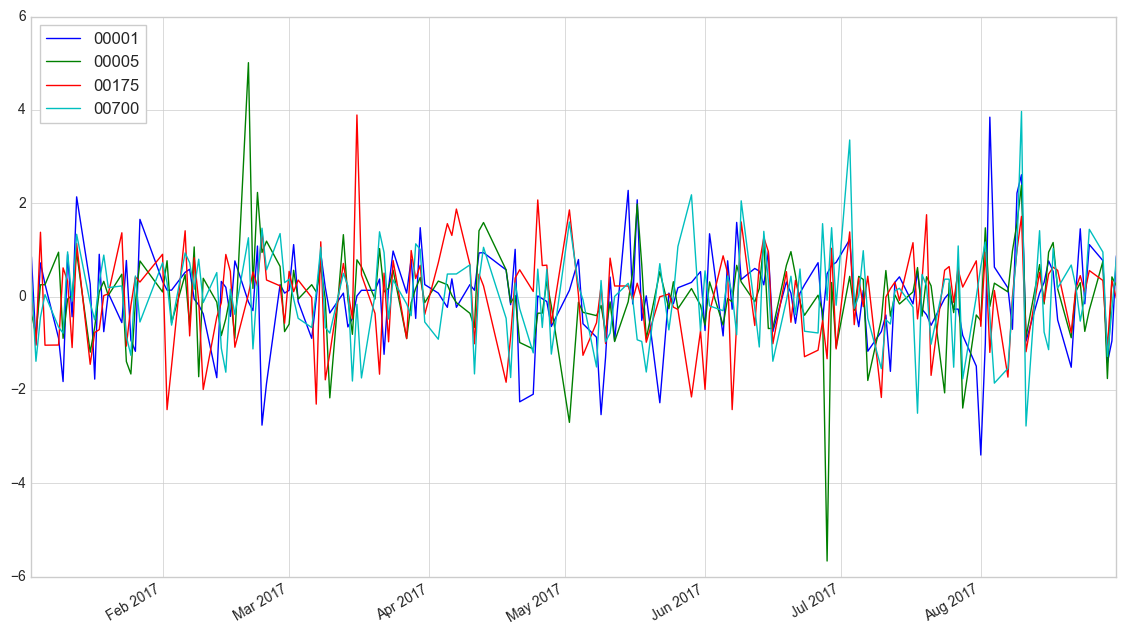

In [28]:
symbols = ["00001","00005","00700","00175"]
res = {}
for c in symbols:
    r = get_stock_data(c,start,end,cols=1)
    res[c] = pd.Series([i[1] for i in r["data"]],index=pd.DatetimeIndex([i[0] for i in r["data"]]))
data2=pd.DataFrame(res)
mult_returns = data2.dropna().pct_change()[1:] # Align all price data and calculate percentage change
norm_returns = (mult_returns - mult_returns.mean(axis=0))/mult_returns.std(axis=0) # Normalise values
norm_returns.plot()
plt.show()

Managing and manipulating time series data has become a lot easier with the `pandas` objects. While we can marvel at how much can be done with so little effort, we have yet produced any meaningful analysis. This is just the beginning!